In [1]:
import os 
import cv2
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline 
from matplotlib import ticker
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import  GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import shuffle

import keras
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Input, Dropout, Flatten, Conv2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop, adam
from keras.utils import np_utils

from keras import backend as K
K.set_image_data_format('channels_first')

Using TensorFlow backend.


In [8]:
# ls ./frames
# ls ../frames/2018-04-20-15-12-38/


# file names are frame_<date-time>_<step (ie. action number)>_<action>.jpeg

In [4]:
# Set up some parmaeters for data loading

#Plug in your training dir

#Other user
#TRAIN_DIR = './frames/something..etc/'

#Andy
TRAIN_DIR = './frames/2018-04-21-20-41-25/'

#Conor
TRAIN_DIR = '../frames/2018-04-20-15-12-38/'

sample_rate = 0.1
ROWS = 64
COLS = 64
CHANNELS = 1

# generate filenames from the data folder and do sampling
image_filenames = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if not i.startswith('.')] # use this for full dataset
image_filenames = random.sample(image_filenames, int(len(image_filenames)*sample_rate))

# Create a data array for image data
count = len(image_filenames)
data = np.ndarray((count, CHANNELS, ROWS, COLS), dtype=np.float)

# Iterate throuigh the filenames and for each one load the image, resize and normalise
for i, image_file in enumerate(image_filenames):
    image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)        
    data[i] = image
    data[i] = data[i]/255
    if i%1000 == 0: print('Processed {} of {}'.format(i, count))

print("Train shape: {}".format(data.shape))

Processed 0 of 9703
Processed 1000 of 9703
Processed 2000 of 9703
Processed 3000 of 9703
Processed 4000 of 9703
Processed 5000 of 9703
Processed 6000 of 9703
Processed 7000 of 9703
Processed 8000 of 9703
Processed 9000 of 9703
Train shape: (9703, 1, 64, 64)


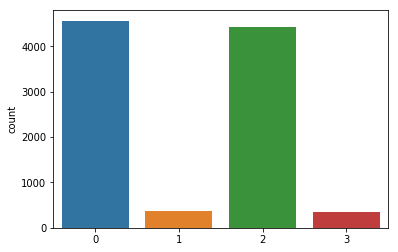

In [9]:
# ACTIONS: 0=no action, 1=left, 2=up, 3=right

# Extract the lables from the last characters in the filename
labels = []
for i in image_filenames:
    l = i[-6:-5]
    labels.append(int(l))
        
# Count the number of clases
num_classes = len(set(labels))

# convert to binary encoded labels
labels_wide = keras.utils.to_categorical(labels, num_classes)

# Plot a bar plot of the 
sns.countplot(labels)

2


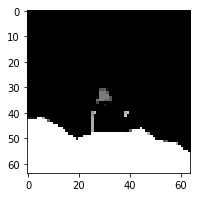

2


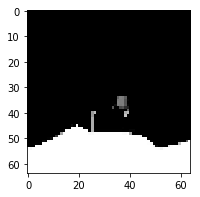

0


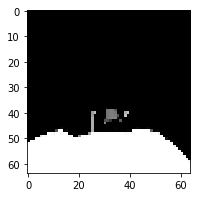

2


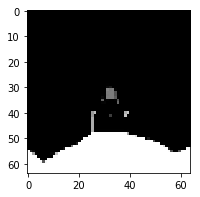

2


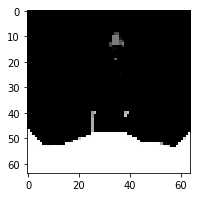

In [10]:
#show some screens
for i in range(0,5):
    idx = random.randint(0, len(labels))
    print(labels[idx])
    plt.figure(figsize=(3,3))
    plt.imshow(data[idx][0], cmap='gray')
    plt.show()

In [11]:
#train test split
train, test, train_labels, test_labels = train_test_split(data, labels, random_state=0, test_size = 0.2, train_size = 0.8)
train_labels_wide = keras.utils.to_categorical(train_labels, num_classes)
test_labels_wide = keras.utils.to_categorical(test_labels, num_classes)

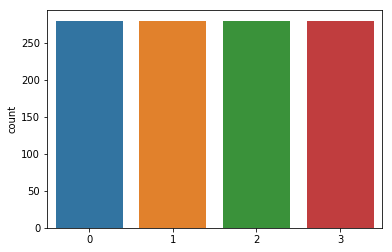

In [12]:
# Apply the random under-sampling
rus = RandomUnderSampler(return_indices=True)
train_rus, train_labels_rus, idx_resampled = rus.fit_sample(train.reshape(len(train), ROWS*COLS*CHANNELS), train_labels)
train_rus, train_labels_rus = shuffle(train_rus, train_labels_rus)
train_rus = train_rus.reshape(len(train_rus), CHANNELS,ROWS, COLS)
sns.countplot(train_labels_rus)
train_labels_rus_wide = keras.utils.to_categorical(train_labels_rus, num_classes)

In [13]:
#Build Keras Models

#build Keras model
def build_fn(dropout_rate=0.0):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=(CHANNELS, ROWS, COLS), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes, activation = 'softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=adam(lr=1e-3), metrics=['accuracy'])
    return model

#wrap Keras model for sklearn API
#model = KerasClassifier(build_fn=func_name, **func_kwargs, verbose=1)
model = KerasClassifier(build_fn=build_fn, dropout_rate=0.1, verbose=1)

In [14]:
#https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

#params for grid search
param_grid = {
    
    #training params
    "epochs":list(range(10,11,5)),   
    "batch_size":[2**i for i in range(7,8)], #powers of 2
    "validation_split":[0.25,],
    "shuffle":[True],
    
    #model structural hyperparams
    #these depend on args for build_fn
    "dropout_rate":[0.1],
    #"optimizer":['SGD', 'RMSprop', 'Adagrad', 'Adam'],
    #"activation":['relu', 'softmax'],
    #Learning rate
    #momentum etc.
    #init_mode #initial weightings
}

#create gridsearch object
grid = GridSearchCV(estimator=model,
                   param_grid=param_grid,
                   n_jobs=1,
                   #verbose=1,
                   refit=True,
                   return_train_score=True)

#run gridsearch
gs_clfs = grid.fit(train_rus, 
                   train_labels_rus_wide,
                  )

Train on 559 samples, validate on 187 samples
Epoch 1/10
559/559 [==============================] - 16s 29ms/step - loss: 1.5670 - acc: 0.2558 - val_loss: 1.4280 - val_acc: 0.2727
Epoch 2/10
559/559 [==============================] - 18s 33ms/step - loss: 1.3873 - acc: 0.3077 - val_loss: 1.4234 - val_acc: 0.2513
Epoch 3/10
559/559 [==============================] - 18s 31ms/step - loss: 1.3453 - acc: 0.3721 - val_loss: 1.3470 - val_acc: 0.3209
Epoch 4/10
559/559 [==============================] - 16s 29ms/step - loss: 1.3273 - acc: 0.3614 - val_loss: 1.3458 - val_acc: 0.3476
Epoch 5/10
559/559 [==============================] - 15s 27ms/step - loss: 1.3188 - acc: 0.3936 - val_loss: 1.3463 - val_acc: 0.3850
Epoch 6/10
559/559 [==============================] - 15s 26ms/step - loss: 1.2855 - acc: 0.4293 - val_loss: 1.3268 - val_acc: 0.4064
Epoch 7/10
559/559 [==============================] - 15s 26ms/step - loss: 1.2569 - acc: 0.4651 - val_loss: 1.3161 - val_acc: 0.3262
Epoch 8/10
559/5

In [16]:
#some printables re:gridsearch
pd.DataFrame(gs_clfs.cv_results_)
gs_clfs.best_estimator_.get_params()
gs_clfs.best_params_


{'batch_size': 128,
 'dropout_rate': 0.1,
 'epochs': 10,
 'shuffle': True,
 'validation_split': 0.25}

In [17]:
#Evaluate with Test dataset

print("****** Test Data ********")
# Make a set of predictions for the validation data
#pred = gs_clfs.best_estimator_.predict_classes(test) for keras style
pred = gs_clfs.best_estimator_.predict(test)  #for estimator objects

# Print performance details
print(metrics.classification_report(test_labels, pred))

# Print confusion matrix
print("Confusion Matrix")
print(metrics.confusion_matrix(test_labels, pred))
#display(pd.crosstab(test_labels, list(pred), margins=True))

#Accuracy
print(metrics.accuracy_score(test_labels, pred))


****** Test Data ********
1941/1941 [==============================] - 27s 14ms/step
             precision    recall  f1-score   support

          0       0.78      0.55      0.65       927
          1       0.11      0.50      0.18        66
          2       0.65      0.63      0.64       882
          3       0.14      0.32      0.20        66

avg / total       0.68      0.57      0.61      1941

Confusion Matrix
[[510 137 240  40]
 [  7  33  26   0]
 [129 116 552  85]
 [  6  11  28  21]]
0.574961360124


In [18]:
#rebuild model without sklearn wrapper (its easier to work with).
dropout_rate = gs_clfs.best_params_['dropout_rate']
params = {k:v for k,v in gs_clfs.best_params_.items() if k!='dropout_rate'}
model = build_fn(dropout_rate=dropout_rate)
history = model.fit(train_rus, train_labels_rus_wide, 
                    **params,
                    verbose=1, )


Train on 840 samples, validate on 280 samples
Epoch 1/10
840/840 [==============================] - 23s 27ms/step - loss: 1.5640 - acc: 0.2667 - val_loss: 1.3984 - val_acc: 0.3643
Epoch 2/10
840/840 [==============================] - 22s 27ms/step - loss: 1.4103 - acc: 0.2857 - val_loss: 1.3693 - val_acc: 0.3500
Epoch 3/10
840/840 [==============================] - 25s 29ms/step - loss: 1.3660 - acc: 0.3560 - val_loss: 1.3571 - val_acc: 0.2679
Epoch 4/10
840/840 [==============================] - 23s 28ms/step - loss: 1.3584 - acc: 0.2667 - val_loss: 1.3546 - val_acc: 0.2893
Epoch 5/10
840/840 [==============================] - 23s 27ms/step - loss: 1.3448 - acc: 0.3690 - val_loss: 1.3415 - val_acc: 0.3464
Epoch 6/10
840/840 [==============================] - 26s 30ms/step - loss: 1.3322 - acc: 0.3286 - val_loss: 1.3336 - val_acc: 0.3143
Epoch 7/10
840/840 [==============================] - 23s 27ms/step - loss: 1.3144 - acc: 0.3607 - val_loss: 1.3184 - val_acc: 0.3321
Epoch 8/10
840/8

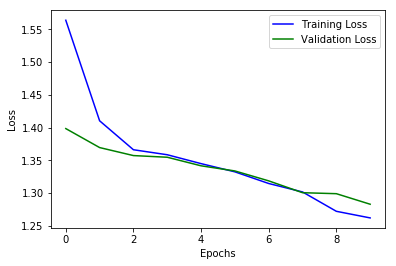

In [19]:
#plot loss curves
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,params['epochs'])[0::2])
plt.legend()
plt.show()

In [20]:
#Evaluate with Test dataset

print("****** Test Data ********")
# Make a set of predictions for the validation data
#pred = gs_clfs.best_estimator_.predict_classes(test) for keras style
pred = model.predict_classes(test)  #for estimator objects

# Print performance details
print(metrics.classification_report(test_labels, pred))

# Print confusion matrix
print("Confusion Matrix")
print(metrics.confusion_matrix(test_labels, pred))
#display(pd.crosstab(test_labels, list(pred), margins=True))

#Accuracy
print(metrics.accuracy_score(test_labels, pred))

****** Test Data ********
             precision    recall  f1-score   support

          0       0.62      0.73      0.67       927
          1       0.17      0.18      0.18        66
          2       0.67      0.20      0.31       882
          3       0.06      0.48      0.11        66

avg / total       0.61      0.46      0.47      1941

Confusion Matrix
[[675  22  73 157]
 [ 27  12   3  24]
 [376  34 180 292]
 [ 19   2  13  32]]
0.463163317877


In [15]:
#save a model
filepath = "player.mod"
model.save(filepath)

#load a model
model = keras.models.load_model("player.mod")

In [16]:
#load a model
model = keras.models.load_model("player.mod")

In [17]:
#Evaluate with Test dataset

print("****** Test Data ********")
# Make a set of predictions for the validation data
#pred = gs_clfs.best_estimator_.predict_classes(test) for keras style
pred = model.predict_classes(test)  #for estimator objects

# Print performance details
print(metrics.classification_report(test_labels, pred))

# Print confusion matrix
print("Confusion Matrix")
print(metrics.confusion_matrix(test_labels, pred))
#display(pd.crosstab(test_labels, list(pred), margins=True))

#Accuracy
print(metrics.accuracy_score(test_labels, pred))

****** Test Data ********
             precision    recall  f1-score   support

          0       0.70      0.45      0.55       375
          1       0.03      0.62      0.06        16
          2       0.59      0.27      0.37       351
          3       0.03      0.07      0.04        28

avg / total       0.61      0.36      0.44       770

Confusion Matrix
[[170 123  60  22]
 [  4  10   1   1]
 [ 66 147  96  42]
 [  4  15   7   2]]
0.361038961039
